In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [3]:
data_path = 'data/'

In [4]:
total = pd.read_csv(data_path + 'total.csv', delimiter=',', header=0, encoding='latin-1')
total

,country,date,co2,population,gdp,co2_cap,gdp_cap
0,Austria,2000-01-01,9726927.646,8003000.0,2.309478e+11,1.215410,28857.653380
1,Austria,2000-02-01,8532685.059,8004700.0,2.321217e+11,1.065959,28998.180236
2,Austria,2000-03-01,8134567.013,8006400.0,2.332957e+11,1.016008,29138.647415
3,Austria,2000-04-01,6546737.758,8008100.0,2.344696e+11,0.817514,29279.054957
4,Austria,2000-05-01,5603261.736,8010100.0,2.352176e+11,0.699525,29365.122366
...,...,...,...,...,...,...,...
4555,Switzerland,2019-08-01,2793634.688,8589980.0,6.281104e+11,0.325220,73121.285498
4556,Switzerland,2019-09-01,3445179.636,8593460.0,6.291429e+11,0.400907,73211.821548
4557,Switzerland,2019-10-01,3819263.405,8596940.0,6.301753e+11,0.444258,73302.284301
4558,Switzerland,2019-11-01,4487169.820,8600420.0,6.312078e+11,0.521738,73392.673846


In [6]:
target_countries = ['Iceland', 'Ireland', 'France', 'Portugal', 'Switzerland']

donor_countries = ['Austria', 'Belgium', 'Bulgaria', 
#                    'Cyprus', 
                   'Croatia', 'Czech Republic',
                   'Germany', 'Greece', 'Hungary', 'Italy', 'Lithuania', 'Netherlands', 
                   'Romania', 'Slovakia', 'Spain']

incl_years = range(2000, 2020)
print(list(incl_years))
incl_countries = target_countries + donor_countries
incl_countries.sort()
print(len(incl_countries))
print(incl_countries)

[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
19
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Lithuania', 'Netherlands', 'Portugal', 'Romania', 'Slovakia', 'Spain', 'Switzerland']


In [7]:
target_country = 'Iceland'
target_var = 'co2'
impl_year = 2010

print(len(donor_countries))
print(donor_countries)

14
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'Germany', 'Greece', 'Hungary', 'Italy', 'Lithuania', 'Netherlands', 'Romania', 'Slovakia', 'Spain']


In [8]:
donors = total.copy()
donors = donors[donors['country'].isin(donor_countries)].reset_index(drop=True)
donors = donors.pivot(index='date',columns=['country'], values=donors.columns[2:])
donors.columns = donors.columns.to_flat_index()
donors.columns = [str(col_name[1]) + ' '+ str(col_name[0]) for col_name in donors.columns]
donors = donors.reindex(sorted(donors.columns), axis=1)
donors = donors.dropna(axis=1)
donors

,Austria co2,Austria co2_cap,Austria gdp,Austria gdp_cap,Austria population,Belgium co2,Belgium co2_cap,Belgium gdp,Belgium gdp_cap,Belgium population,...,Slovakia co2,Slovakia co2_cap,Slovakia gdp,Slovakia gdp_cap,Slovakia population,Spain co2,Spain co2_cap,Spain gdp,Spain gdp_cap,Spain population
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,9726927.646,1.215410,2.309478e+11,28857.653380,8003000.0,1.351577e+07,1.319642,2.767987e+11,27025.844562,1.024200e+07,...,5269153.288,0.975968,5.929290e+10,10982.403823,5.398900e+06,31920310.35,0.788572,8.499581e+11,20997.714842,4.047860e+07
2000-02-01,8532685.059,1.065959,2.321217e+11,28998.180236,8004700.0,1.287137e+07,1.256520,2.789002e+11,27226.598549,1.024367e+07,...,4567891.347,0.846010,5.976010e+10,11068.051611,5.399333e+06,27856422.79,0.687906,8.562724e+11,21145.382587,4.049453e+07
2000-03-01,8134567.013,1.016008,2.332957e+11,29138.647415,8006400.0,1.266509e+07,1.236181,2.810017e+11,27427.287220,1.024533e+07,...,4272754.063,0.791285,6.022730e+10,11153.685653,5.399767e+06,28857737.94,0.712353,8.625867e+11,21292.934172,4.051047e+07
2000-04-01,6546737.758,0.817514,2.344696e+11,29279.054957,8008100.0,1.098386e+07,1.071909,2.831032e+11,27627.910608,1.024700e+07,...,3213318.598,0.595037,6.069450e+10,11239.305952,5.400200e+06,27973346.38,0.690250,8.689010e+11,21440.369734,4.052640e+07
2000-05-01,5603261.736,0.699525,2.352176e+11,29365.122366,8010100.0,9.315180e+06,0.908887,2.845867e+11,27767.265099,1.024900e+07,...,2782593.256,0.515238,6.112147e+10,11317.532620,5.400600e+06,25280067.38,0.623520,8.742759e+11,21563.562011,4.054413e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,5968172.223,0.671719,5.345382e+11,60162.412267,8884920.0,7.374783e+06,0.641319,6.497641e+11,56504.175870,1.149940e+07,...,2704287.648,0.495777,1.842784e+11,33783.795081,5.454640e+06,23326657.18,0.494488,2.051219e+12,43482.595890,4.717334e+07
2019-09-01,6944311.845,0.781327,5.352602e+11,60223.883418,8887840.0,7.963942e+06,0.692348,6.523629e+11,56713.403693,1.150280e+07,...,3029328.188,0.555322,1.848386e+11,33883.752392,5.455080e+06,23553543.13,0.499048,2.053046e+12,43499.519673,4.719698e+07
2019-10-01,7984085.903,0.898021,5.359823e+11,60285.314191,8890760.0,9.034334e+06,0.785171,6.549618e+11,56922.507865,1.150620e+07,...,3682270.154,0.674962,1.853987e+11,33983.693580,5.455520e+06,24694717.71,0.522965,2.054873e+12,43516.426510,4.722062e+07


In [16]:
for col in donors.columns:
    donor_series = donors[col]
    adf_test = adfuller(donor_series)
    if adf_test[1] < 0.05:
        print(f'{col}: Stationary')
    if adf_test[1] >= 0.05:
        print(f'{col}: Non-stationary ({adf_test[1]})')

Austria co2: Stationary
Austria co2_cap: Non-stationary (0.1460555130736783)
Austria gdp: Non-stationary (0.9989422639009633)
Austria gdp_cap: Non-stationary (0.9978006620026617)
Austria population: Non-stationary (0.9827498531294232)
Belgium co2: Non-stationary (0.43535770823312164)
Belgium co2_cap: Non-stationary (0.7504442573713069)
Belgium gdp: Non-stationary (1.0)
Belgium gdp_cap: Non-stationary (1.0)
Belgium population: Non-stationary (0.811619041707625)
Bulgaria co2: Stationary
Bulgaria co2_cap: Stationary
Bulgaria gdp: Non-stationary (0.9987140635850552)
Bulgaria gdp_cap: Non-stationary (0.999083770319759)
Bulgaria population: Non-stationary (0.4134445702997761)
Croatia co2: Non-stationary (0.5619773778701027)
Croatia co2_cap: Non-stationary (0.27922623911157707)
Croatia gdp: Non-stationary (0.9902867911527463)
Croatia gdp_cap: Non-stationary (0.9957495815403118)
Croatia population: Non-stationary (0.45248489048857116)
Czech Republic co2: Non-stationary (0.8720445617443311)
Cze

In [160]:
X_cols = list(donors.columns)
X_orig = donors[X_cols]

y = np.array(total[total['country']==target_country][target_var]).reshape(-1,1)
X = np.array(donors[X_cols])

### Sandardization of data ###
PredictorScaler = StandardScaler()
TargetVarScaler = StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X)
TargetVarScalerFit = TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X = PredictorScalerFit.transform(X)
y = TargetVarScalerFit.transform(y)
 
# Split the data into training and testing set
ts = (2019 - impl_year + 1)*12
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(108, 70)
(108, 1)
(120, 70)
(120, 1)


Text(0, 0.5, 'weights')

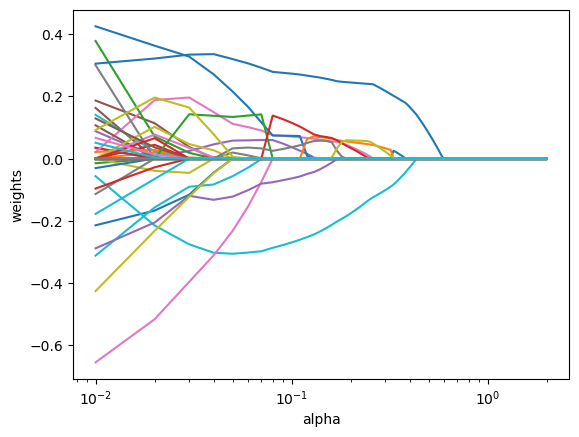

In [161]:
alphas = np.arange(0.01,2,0.01)

lasso = Lasso(max_iter=10000)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [162]:
# define model evaluation method
tscv = TimeSeriesSplit(n_splits=10)
# define model
model = LassoCV(
                alphas=np.arange(0.01, 1, 0.001), 
#                 alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                cv=tscv,
                max_iter=100000,
                tol=0.00001
               )
# fit model
model.fit(X_train, y_train.ravel())
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 0.078000


In [163]:
# print(model.alpha_)
# print(model.coef_X)
# print(model.intercept_)
# print(model.score)
# print(model.get_params)

coefs = list(model.coef_)
coef_index = [i for i, val in enumerate(coefs) if val != 0]
coef_index

print(len(X_orig.columns[coef_index]))
print(X_orig.columns[coef_index])

coeffs = model.coef_
print(coeffs[coeffs != 0])

10
Index(['Austria pop_stat', 'Belgium pop_stat', 'Croatia co2_stat',
       'Germany co2_stat', 'Italy co2_cap_stat', 'Lithuania co2_cap_stat',
       'Netherlands co2_cap_stat', 'Netherlands pop_stat', 'Slovakia gdp_stat',
       'Spain gdp_cap_stat'],
      dtype='object')
[ 0.05960373 -0.28882113 -0.01316892  0.07799976  0.08164623  0.00231002
  0.28147025 -0.07653082  0.13909774  0.02686358]


[]

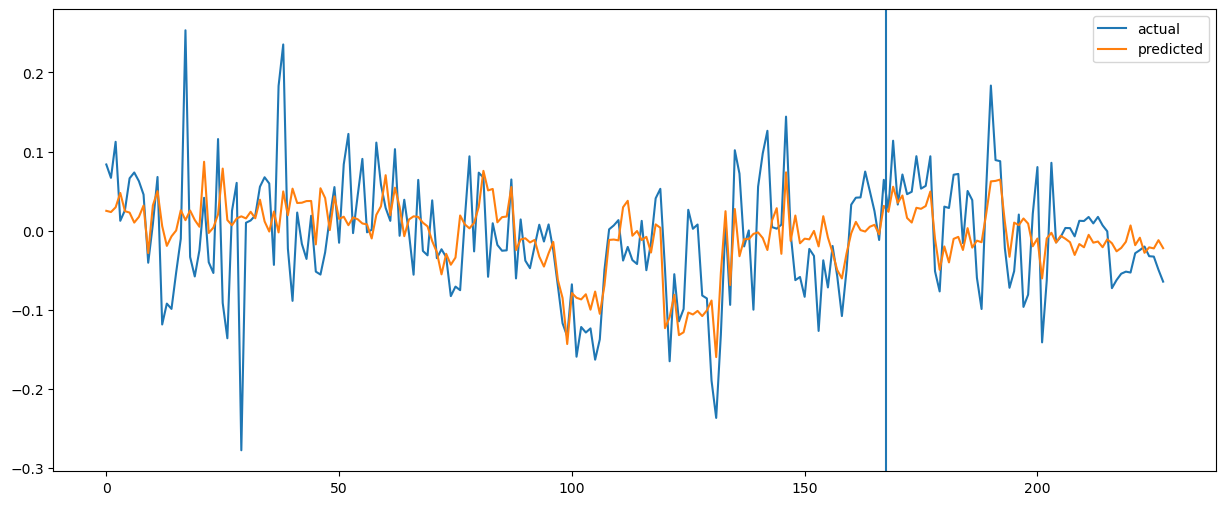

In [164]:
x_ax = X_orig.index
act = TargetVarScalerFit.inverse_transform(y)
pred = TargetVarScalerFit.inverse_transform(model.predict(X).reshape(-1, 1))

plt.figure(figsize=(15,6))
plt.plot(act, label='actual')
plt.plot(pred, label='predicted')
plt.axvline(x = impl_year/12)
plt.legend()
plt.plot()

[-0.64086319]
[0.36773097]


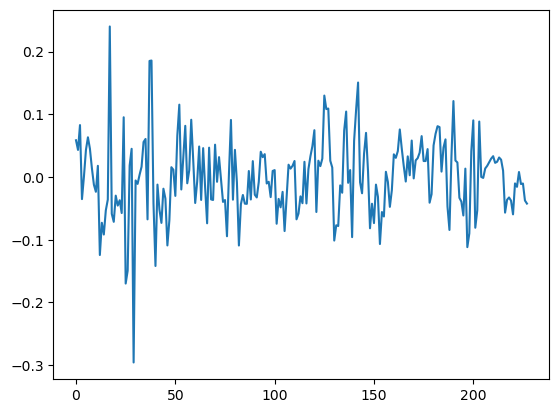

In [165]:
diff = act - pred
print(sum(diff[:round(impl_year/12)]))
print(sum(diff[round(impl_year/12):]))

plt.plot(diff)

[]

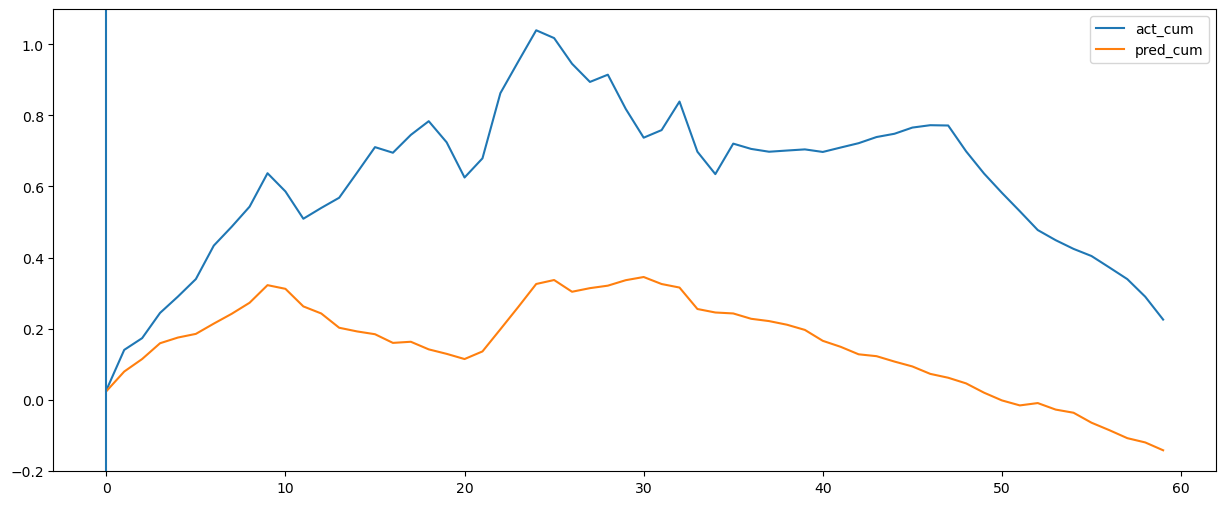

In [166]:
# act_cum = np.cumsum(act)
# pred_cum = np.cumsum(pred)

act_cum = np.cumsum(act[round(impl_year/12):])
pred_cum = np.cumsum(pred[round(impl_year/12):])

plt.figure(figsize=(15,6))
plt.plot(act_cum, label='act_cum')
plt.plot(pred_cum, label='pred_cum')
# plt.axvline(x = round(impl_year/12))
plt.axvline(x = 0)
plt.legend()
plt.plot()